In [29]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load data 

In [71]:
reload(hp)

with open('../data/converted/amazon-google/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

data['train_2']['price'] = data['train_2']['price'].apply(hp.str_to_num)
data['val_2']['price'] = data['val_2']['price'].apply(hp.str_to_num)
data['test_2']['price'] = data['test_2']['price'].apply(hp.str_to_num)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-google/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model 

In [17]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-google/glove-300.matrix.npy',
                        text_columns = ['name', 'description'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[20, 10],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 2


# Train model 

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 104000 samples, validate on 13000 samples
Epoch 1/20
104000/104000 [==============================] - 12s 116us/step - loss: 0.0971 - acc: 0.9860 - val_loss: 0.0371 - val_acc: 0.9896
Epoch 2/20
104000/104000 [==============================] - 11s 109us/step - loss: 0.0297 - acc: 0.9907 - val_loss: 0.0254 - val_acc: 0.9930
Epoch 3/20
104000/104000 [==============================] - 11s 108us/step - loss: 0.0258 - acc: 0.9930 - val_loss: 0.0240 - val_acc: 0.9938
Epoch 4/20
104000/104000 [==============================] - 11s 107us/step - loss: 0.0253 - acc: 0.9933 - val_loss: 0.0239 - val_acc: 0.9945
Epoch 5/20
104000/104000 [==============================] - 11s 106us/step - loss: 0.0251 - acc: 0.9934 - val_loss: 0.0235 - val_acc: 0.9945
Epoch 6/20
104000/104000 [==============================] - 11s 108us/step - loss: 0.0250 - acc: 0.9934 - val_loss: 0.0238 - val_acc: 0.9936
Epoch 7/20
104000/104000 [==============================] - 11s 107us/step - loss: 0.0250 - acc: 0.9935

# Learning curves

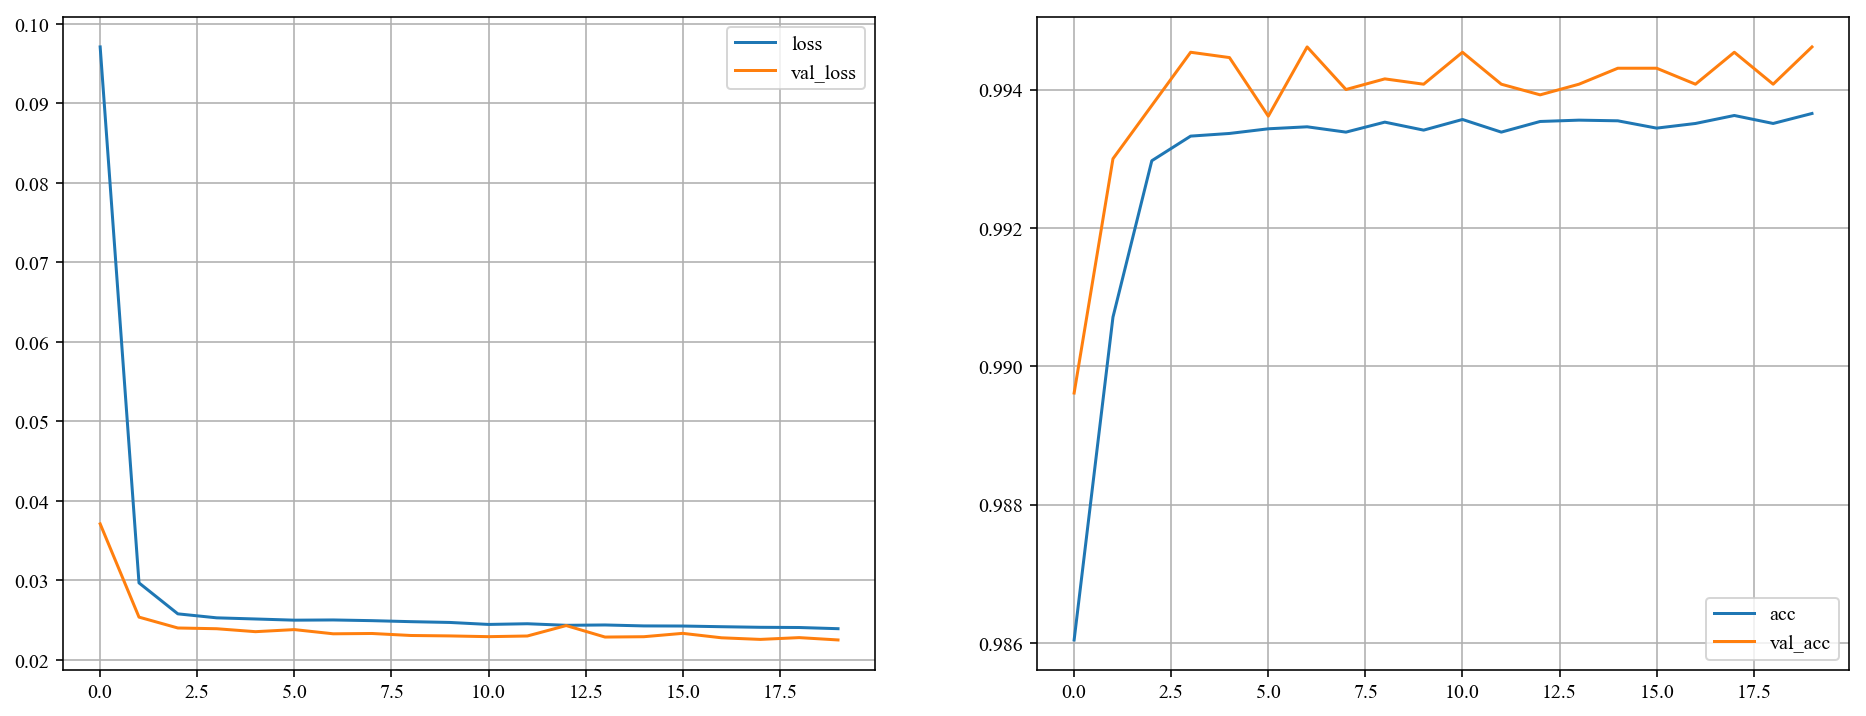

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)

# Evaluate model 

In [28]:
y_val_pred = model.predict(X_val)[:,1]
y_val_ = data['val_y'].values.squeeze()

In [44]:
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12865
          1       0.86      0.58      0.69       135

avg / total       0.99      0.99      0.99     13000

[[12852    13]
 [   57    78]]


In [90]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['name', 'description']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)

In [91]:
df_examine.sample(10)

,id1,name,description,price,id2,name,description,price
1313,b000i2qubi,intuit inc. quickbooks pos : pro multistore 6.0,quickbooks point-of-sale pro multi-store 6.0 RETAIL-MANAGEMENT software turns any pc into a cash register that does what no ordinary cash register can do : it automatically keeps track of your detailed inventory customers sales orders layaways and employee commissions and tips while you and your employees are ringing up sales in up to 10 different locations. it 's a high-powered RETAIL-MANAGEMENT system that tracks inventory sales and customer information to help save you time and better serve your customers. pro features not included with pos basic 6.0 include refinements and extras that let you : create special orders for items not tracked in inventory generate purchase orders automatically at preset inventory levels track multiple vendors and upc codes per item track inventory assemblies ( kits ) and items sold as groups track serial numbers customize price tags receipts and more with the document designer create customizable fields for vendors items and customers track employe...,1399.95,http://www.google.com/base/feeds/snippets/12835181529749808477,intuit qb pos 6.0 pro multi store sw,qb pos 6.0 pro multistore retail mngmt software. has all the features in basic plus the ability to manage up to ten stores from a single office.,1054.99
925,b000hlt57q,intriguing development iremember digital scrapbooking 2.0,iremember digital scrapbook makes it easier than ever to create gorgeous scrapbooks on your mac ! finish a page in only minutes - just add a blank page to your scrapbook using iremember drag in a template add your photos resize crop and share add text to your creations - familiar poems quotations scripture verses and more,39.95,http://www.google.com/base/feeds/snippets/18385266399097496621,iremember 2.0 - intriguing development,turn digital photos into memories with IREMEMBER. easily create stunning scrapbooks your family will treasure for a lifetime. use templates to create a page in minutes ! drag and drop pictures from iphoto ? crop resize and arrange them on your ...,32.99
3131,b000eplmpi,nova development printmaster gold v 17.0,printmaster gold 17 gives creative home users a chance to get creative & use their IMAGINATIONS. everything from a bridal shower invitation to youth soccer league rosters can be made quickly and easily.,19.95,http://www.google.com/base/feeds/snippets/13683578637114771147,printmaster gold v 17.0 ( win 98 me 2000 xp ),if you ve got a passion for creative self-expression you ll find endless inspiration in this sophisticated easy-to-use program. enjoy all of the great features you expect from PRINTMASTERÅ½ plus brilliant new upgrades that make personal creativity ...,19.95
11611,b0009stm6g,knowledge adventure jumpstart learning games phonics ( pc & mac ),NaN,9.99,http://www.google.com/base/feeds/snippets/7117788517647646539,jumpstart phonics ( jc ),welcome to camp READALOT !,9.90
8415,b000j1h08k,global marketing partners bitdefender antivirus 10.0 [ 2 year subscription for 2 pcs ],MODEL- BDCD00105WI VENOR- bitdefender FEATURES- bitdefender antivirus V10- small box antivirus v10 delivers a one-two security punch integrating todays most powerful antivirus and antispyware modules into one convenient package. its easy to use and updates itself automatically making it truly an install and forget solution. * antivirus the purpose of the antivirus module is to ensure detection and removal of all viruses in the wild. bitdefender antivirus uses robust scan engines certified by ICSA labs virus bulletin checkmark CHECKVIR and TUV. - improved proactive detection B-HAVE ( behavioral heuristic analyzer in virtual environments ) emulates a virtual COMPUTER-INSIDE-A-COMPUTER where pieces of software are run in order to check for potential malware behavior. this bitdefender proprietary technology represents a new security layer that keeps the operating system safe from unknown viruses by detecti

# Save model and histories

In [95]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-google-full-averaging.csv', index=False)
model.save('../data/models/amazon-google-full-averaging')

# Test model 

In [104]:
y_test_pred = model.predict(X_test)[:,1]
y_test_ = data['test_y'].values.squeeze()

In [105]:
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     12865
          1       0.83      0.50      0.63       135

avg / total       0.99      0.99      0.99     13000

[[12851    14]
 [   67    68]]
